HighTime - Web traffic analysis neural model
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this assignment is to train a simple DNN model to make predictions over web traffic.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt

Let us mimic real traffic data by using normal distribution:

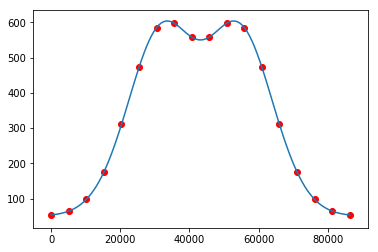

In [2]:
total_seconds = 24 * 3600
total_rps = 1000

def gaussian(x, mu = 0, sig = 1):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def rps(x):
  return (gaussian(x, total_seconds/2, 12000) * 5 - gaussian(x, total_seconds/2, 10000) * 4 ) * 500 + 50

def fake_train(batch_size=100):
  x = np.linspace(0, total_seconds, batch_size)
  return x, rps(x)

x = np.linspace(0, total_seconds, 120)
plt.plot(x, rps(x))
plt.scatter(fake_train(18)[0], fake_train(18)[1], color='red')
plt.show()

Function to generate a training batch:

In [3]:
def secs_to_time(time_in_seconds):
  hours = time_in_seconds // 3600
  minutes = (time_in_seconds - hours * 3600) // 60
  seconds = time_in_seconds - hours * 3600 - minutes * 60
  return hours, minutes, seconds

def time_to_secs(hour, minutes, seconds):
  return hour * 3600 + minutes * 60 + seconds

def time_to_squashed_secs(hour, minutes, seconds):
  return time_to_secs(hour, minutes, seconds) / total_seconds

def secs_to_string(sec):
  result = ':'.join([('%d' % i) for i in secs_to_time(sec)])
  return result + (' (%dth second)' % sec)

def squashed_secs_to_string(sq_sec):
  return secs_to_string(sq_sec * total_seconds)

def squashed_secs_to_hours(sq_secs):
  return [sq_sec * 24 for sq_sec in sq_secs]

def squashed_label_to_label(sq_label):
  return sq_label * total_rps

def squashed_labels_to_labels(sq_labels):
  return [sq_label * total_rps for sq_label in sq_labels]

class BatchGenerator(object):
  def __init__(self, batch_size):
    self._batch_size = batch_size

  def spit(self):
    dataset = np.random.uniform(0, total_seconds, self._batch_size)
    labels  = rps(dataset)
    
    dataset = (dataset / total_seconds).reshape(self._batch_size, 1)
    labels  = (labels  / total_rps    ).reshape(self._batch_size, 1)

    return dataset, labels

Generate valid and test datasets:

In [4]:
generator = BatchGenerator(120)

# Test dataset
test_dataset, test_labels = generator.spit()
# sort it for a nice view
sorting = np.array([test_dataset, test_labels]).reshape(2, -1).T
sorting = sorting[np.argsort(sorting[:, 0])]
test_dataset, test_labels = sorting.T.reshape(2, -1, 1)

print('Test size: %s', test_dataset.shape)
print('Ten test pairs as an example:')

for sec, label in list(zip(test_dataset, test_labels))[:10]:
  print('Time %s => %03.2f rps' % (squashed_secs_to_string(sec), squashed_label_to_label(label)))

Test size: %s (120, 1)
Ten test pairs as an example:
Time 0:3:57 (237th second) => 53.92 rps
Time 0:56:34 (3394th second) => 59.47 rps
Time 1:22:20 (4940th second) => 64.18 rps
Time 1:54:51 (6891th second) => 72.96 rps
Time 2:1:11 (7271th second) => 75.13 rps
Time 2:3:37 (7417th second) => 76.01 rps
Time 2:42:43 (9763th second) => 94.06 rps
Time 2:43:30 (9810th second) => 94.51 rps
Time 2:55:19 (10519th second) => 101.70 rps
Time 3:12:23 (11543th second) => 113.71 rps


Simple NN Model with one hidden layer and ReLU activation function.

In [8]:
feature_size = 1 # number of features to feed input
num_labels = 1 # number of output labels
num_hidden_nodes = 35
batch_size = 100
learning_rate = 0.05

graph = tf.Graph()
with graph.as_default():
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  x = tf.placeholder(tf.float32, shape=(batch_size, feature_size))
  y = tf.placeholder(tf.float32, shape=(batch_size, 1))
  tf_test_data = tf.placeholder(tf.float32, shape=(None, feature_size))

  # Hidden layer variables
  weights1 = tf.Variable(tf.truncated_normal([feature_size, num_hidden_nodes]))
  biases1  = tf.Variable(tf.zeros([num_hidden_nodes]))

  # Variables.
  weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2  = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  z0 = tf.matmul(x, weights1) + biases1
  a0 = tf.nn.relu(z0)

  z1 = tf.matmul(a0, weights2) + biases2
  a1 = z1
  error = a1 - y
  loss = tf.reduce_mean(tf.square(error))

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  # Prediction for test data.
  tf_prediction_hidden = tf.nn.relu(tf.matmul(tf_test_data, weights1) + biases1)
  tf_prediction        = tf.matmul(tf_prediction_hidden, weights2) + biases2

In [9]:
num_steps = 1051
generator = BatchGenerator(batch_size)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels))
          / predictions.shape[0])

session = tf.Session(graph=graph)

with graph.as_default():
  with session.as_default():
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
      batch_data, batch_labels = generator.spit()
      feed_dict = {x : batch_data, y : batch_labels}
      _, l = session.run(
        [optimizer, loss], feed_dict=feed_dict)
      if (step % 50 == 0):
        print("Minibatch loss at step %d: %f" % (step, l))
    predicted = tf_prediction.eval(feed_dict={tf_test_data: test_dataset})

session.close()

Initialized
Minibatch loss at step 0: 15.752242
Minibatch loss at step 50: 0.008410
Minibatch loss at step 100: 0.006527
Minibatch loss at step 150: 0.004133
Minibatch loss at step 200: 0.004286
Minibatch loss at step 250: 0.003489
Minibatch loss at step 300: 0.002693
Minibatch loss at step 350: 0.002414
Minibatch loss at step 400: 0.002304
Minibatch loss at step 450: 0.002508
Minibatch loss at step 500: 0.002282
Minibatch loss at step 550: 0.002013
Minibatch loss at step 600: 0.002318
Minibatch loss at step 650: 0.002152
Minibatch loss at step 700: 0.001918
Minibatch loss at step 750: 0.001873
Minibatch loss at step 800: 0.001787
Minibatch loss at step 850: 0.001722
Minibatch loss at step 900: 0.001260
Minibatch loss at step 950: 0.001619
Minibatch loss at step 1000: 0.001673
Minibatch loss at step 1050: 0.001715


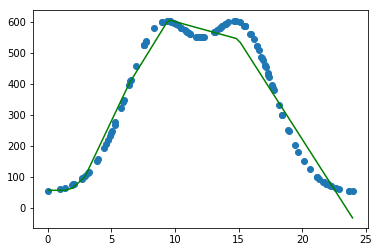

In [10]:
predicted_test = np.array(squashed_labels_to_labels(predicted.reshape(predicted.shape[0])))

plt.scatter(squashed_secs_to_hours(test_dataset), squashed_labels_to_labels(test_labels))
plt.plot(squashed_secs_to_hours(test_dataset), predicted_test, color='green')
plt.show()